In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from crypr.zoo import LSTM_triggerNG
from crypr.util import get_project_path

Using TensorFlow backend.


In [2]:
SYM = 'BTC'
Tx = 72
Ty = 1
wavelet = 'MORLET'
N = 28
data_dir = join(get_project_path(), 'data', 'processed')

"""
Import Data.
"""
def load_preprocessed_data(from_dir, sym, tx, wavelet, n=None):
    X_train = np.load(join(data_dir, 'X_train_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    X_test = np.load(join(data_dir, 'X_test_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    y_train = np.load(join(data_dir, 'y_train_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    y_test = np.load(join(data_dir, 'y_test_{}_{}_{}x{}.npy'.format(sym, wavelet, n, tx)))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_preprocessed_data(data_dir, SYM, Tx, wavelet, N)
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((5629, 28, 72), (297, 28, 72), (297, 1), (5629, 1))

In [3]:
"""
Evaluate Dummy Models.
"""
for strategy in ['mean', 'median', 'constant']:
    if strategy == 'constant':
        dummy = DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy = DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    dummy_predict_train = dummy.predict(X_train)
    
    p('\nPerformance on train data:')
    p('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    p('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    p('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    p('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.34418661889736685
mean MSE: 0.45202903641413206

Performance on test data:
mean MAE: 0.45173221695820975
mean MSE: 0.8343847260888769

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.3439532128639904
median MSE: 0.45216779099575444

Performance on test data:
median MAE: 0.45142488321070506
median MSE: 0.8326107537924785

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.34397430097686643
constant MSE: 0.4520854721366878

Performance on test data:
constant MAE: 0.45151294514686796
constant MSE: 0.8332213120672572


### Define RNN

In [4]:
tx, num_channels = X_train.shape[1:]
ty = y_train.shape[1]
model = LSTM_triggerNG(tx=tx, num_channels=num_channels, num_outputs=ty)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 72)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 196)           113092    
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 196)           784       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 196)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 196)           0         
_________________________________________________________________
lstm_1 (LSTM)        

### Train RNN 

In [5]:
"""
Set model training parameters.
"""
epochs = 10
batch_size = 32
learning_rate = 1e-3
beta_1 = 0.9
beta_2 = 0.999
decay = 0.01  # TODO: calculated decay rate -- decay = learning_rate / epochs

"""
Logging params.
"""
log_dir = join(get_project_path(), 'notebooks', 'logs', 'cwt_rnn_model_dev')
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, 
                          write_graph=True, write_grads=False, write_images=False)

"""
Compile and fit model.
"""

opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)

model.compile(loss='mae', optimizer=opt)

fit = model.fit(X_train, 
                y_train,
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(X_test, y_test),
                callbacks=[tensorboard],
               )

Instructions for updating:
Use tf.cast instead.
Train on 5629 samples, validate on 297 samples
Epoch 1/10
5629/5629 [==============================] - 12s 2ms/step - loss: 1.7945 - val_loss: 0.5672
Epoch 2/10
5629/5629 [==============================] - 9s 2ms/step - loss: 1.4250 - val_loss: 0.5380
Epoch 3/10
5629/5629 [==============================] - 10s 2ms/step - loss: 1.2603 - val_loss: 0.5333
Epoch 4/10
5629/5629 [==============================] - 10s 2ms/step - loss: 1.1520 - val_loss: 0.5019
Epoch 5/10
5629/5629 [==============================] - 8s 1ms/step - loss: 1.0820 - val_loss: 0.4910
Epoch 6/10
5629/5629 [==============================] - 8s 1ms/step - loss: 1.0022 - val_loss: 0.4784
Epoch 7/10
5629/5629 [==============================] - 12s 2ms/step - loss: 0.9298 - val_loss: 0.4756
Epoch 8/10
5629/5629 [==============================] - 8s 2ms/step - loss: 0.8879 - val_loss: 0.4624
Epoch 9/10
5629/5629 [==============================] - 8s 1ms/step - loss: 0.8472 - 

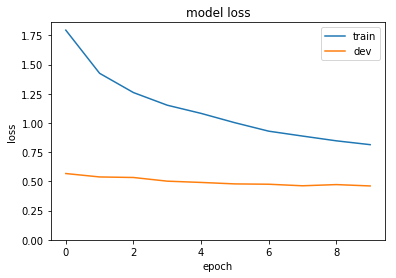

In [6]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

### Predict 

In [7]:
backtest = model.predict(X_train)
prediction = model.predict(X_test)

# Select price prediction in multiple output models
if len(backtest) == 2:
    backtest = backtest[1]
    prediction = prediction[1]

### Evaluate Predictions on Test (unseen) Data

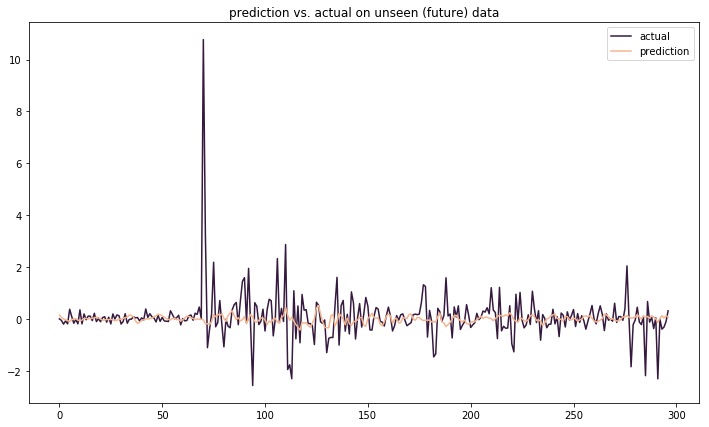

In [8]:
fig,ax = plt.subplots(figsize=(12,7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()
plt.show()

### Evaluate Predictions for Training Data

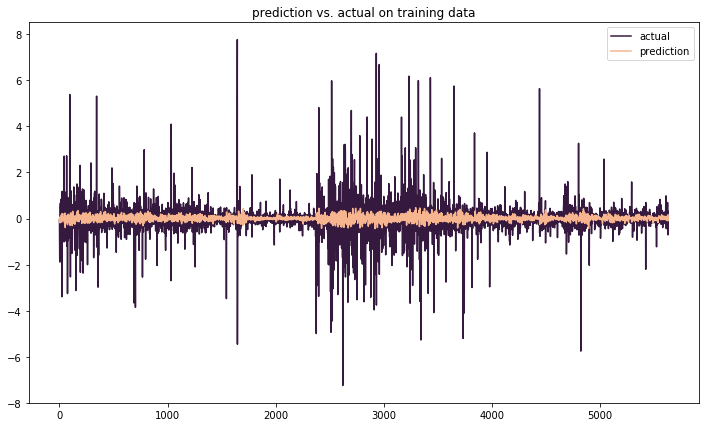

In [9]:
fig,ax = plt.subplots(figsize=(12,7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()
plt.show()

In [10]:
# Save the model
model_path = join(get_project_path(), 'models', 'cwt_rnn_model_dev_{}.h5'.format(SYM))
model.save(filepath=model_path)